# Data Visualization - Communicate data findings - Chicago bike share trips dataset

## Table of content

- [Import Packages](https://jocelyngiquel.github.io/udacity-data-visualization/data_viz_divvy.html#Import-Packages)
- [Import Data](https://jocelyngiquel.github.io/udacity-data-visualization/data_viz_divvy.html#Import-Data)
- [Data Wrangling](https://jocelyngiquel.github.io/udacity-data-visualization/data_viz_divvy.html#Data-Wrangling)
- [Graph Analysis](https://jocelyngiquel.github.io/udacity-data-visualization/data_viz_divvy.html#Graph-analysis)
    - [Trip duration distribution](https://jocelyngiquel.github.io/udacity-data-visualization/data_viz_divvy.html#Trip-duration-distribution)
    - [Subscriber/Customer distribution](https://jocelyngiquel.github.io/udacity-data-visualization/data_viz_divvy.html#Subscriber/Customer-distribution)
    - [Daily trips pattern](https://jocelyngiquel.github.io/udacity-data-visualization/data_viz_divvy.html#Daily-trips-pattern)
    - [Weekly distribution](https://jocelyngiquel.github.io/udacity-data-visualization/data_viz_divvy.html#Weekly-distribution)
    - [Monthly Distribution](https://jocelyngiquel.github.io/udacity-data-visualization/data_viz_divvy.html#Monthly-Distribution)
    - [Visualising Geospatial Station Data](https://jocelyngiquel.github.io/udacity-data-visualization/data_viz_divvy.html#Visualising-Geospatial-Station-Data)
- [References](https://jocelyngiquel.github.io/udacity-data-visualization/data_viz_divvy.html#References)

## Import Packages

In [1]:
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import folium

%matplotlib inline

## Import Data
[Back to top](https://jocelyngiquel.github.io/udacity-data-visualization/data_viz_divvy.html#Data-Visualization---Communicate-data-findings---Chicago-bike-share-trips-dataset)

The Divvy's trip (Chicago bike share system) data is available for public use on the [Divvy website](https://www.divvybikes.com/system-data).

Each trip is anonymized and includes:
- Trip start day and time
- Trip end day and time
- Trip start station
- Trip end station
- Rider type (Member and Single Ride)
- If a Member trip, it will also include Member’s gender and year of birth

For this analysis, we will focus on the data from 2017. Because of the size of the datasets, necessarry data for this analysis is not provided in this github repository.

The user will need to download the data from Divvy's website mentioned above

In [2]:
Chicago_2017_Q1 = pd.read_csv('Divvy_Trips_2017_Q1.csv')
Chicago_2017_Q2 = pd.read_csv('Divvy_Trips_2017_Q2.csv')
Chicago_2017_Q3 = pd.read_csv('Divvy_Trips_2017_Q3.csv')
Chicago_2017_Q4 = pd.read_csv('Divvy_Trips_2017_Q4.csv')

Additonal station data (city, geospatial coordinates) is available via a live JSON feed.

In [3]:
url_chicago_stations = 'https://feeds.divvybikes.com/stations/stations.json'
stations_json = requests.get(url_chicago_stations)
stations_data = stations_json.json()
chicago_stations_df = pd.DataFrame(stations_data['stationBeanList'])

In [3]:
chicago_2017 = pd.concat([Chicago_2017_Q1,
                          Chicago_2017_Q2,
                          Chicago_2017_Q3,
                          Chicago_2017_Q4])

## Data Wrangling
[Back to top](https://jocelyngiquel.github.io/udacity-data-visualization/data_viz_divvy.html#Data-Visualization---Communicate-data-findings---Chicago-bike-share-trips-dataset)

For this analysis purposes, we need to compute the duration of each trip based on the start and end time tag. For this, both the start and end time data need to be converted to a datetime type.

WARNING: The cell below is computing intensive.

In [233]:
chicago_2017.end_time = pd.to_datetime(chicago_2017.end_time)
chicago_2017.start_time = pd.to_datetime(chicago_2017.start_time)
chicago_2017['duration'] = (chicago_2017.end_time - chicago_2017.start_time).astype('timedelta64[m]')
chicago_2017['duration'] = chicago_2017['duration'].round(2)

For this analysis purposes, we extract the hour, the day and the month of the trip based on the start time tag

In [ ]:
chicago_2017['day_hour'] = chicago_2017.start_time.dt.hour
chicago_2017['day'] = chicago_2017.start_time.dt.day_name()
chicago_2017['month'] = chicago_2017.start_time.dt.month_name()

For this analysis purposes, we classify each trip depending on the day of the week, either working day or weekend.

In [ ]:
workdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
weekends = ['Saturday', 'Sunday']

chicago_2017.loc[chicago_2017.day.isin(workdays), 'workdays'] = 'workdays'
chicago_2017.loc[chicago_2017.day.isin(weekends), 'weekends'] = 'weekends'

unpivot_columns = ['workdays', 'weekends']
id_columuns = list(set(chicago_2017.columns.tolist())-set(unpivot_columns))

chicago_2017 = pd.melt(chicago_2017, id_vars = id_columuns,
                       value_vars = unpivot_columns,
                       var_name = 'cat', value_name = 'day_cat')
chicago_2017.drop(columns='cat', inplace=True)

chicago_2017 = chicago_2017.dropna(subset=['day_cat'])

The Divvy dataset contains data about station not located in Chicago, we want to restrict our analysis to Chicago hence will exclude the station from other cities

In [4]:
chicago_stations_df.city.value_counts()

Chicago     549
Chicago      41
Evanston     14
Name: city, dtype: int64

In [5]:
chicago_stations_id = chicago_stations_df.query('city != "Evanston"').id.astype(int).tolist()
chicago_2017 = chicago_2017[chicago_2017.from_station_id.isin(chicago_stations_id)]

The analysis of the duration distribution is showing outliers that need to be excluded for data quality and to avoid distorsion. We exclude all trips with a negative duration, and all trips with a duration greater than the 95 percentile.

In [6]:
chicago_2017.duration.describe(percentiles=[.25,.5,.75,.95])

count    3.801404e+06
mean     1.551220e+01
std      2.596393e+01
min     -5.200000e+01
25%      6.000000e+00
50%      1.100000e+01
75%      1.900000e+01
95%      3.600000e+01
max      1.438000e+03
Name: duration, dtype: float64

In [7]:
chicago_2017 = chicago_2017.query('duration > 0')

In [8]:
chicago_2017.duration.describe(percentiles=[.25,.5,.75,.95])

count    3.801393e+06
mean     1.551236e+01
std      2.596378e+01
min      1.000000e+00
25%      6.000000e+00
50%      1.100000e+01
75%      1.900000e+01
95%      3.600000e+01
max      1.438000e+03
Name: duration, dtype: float64

In [9]:
chicago_2017 = chicago_2017.query('duration < 37')

In [10]:
chicago_2017.duration.describe(percentiles=[.25,.5,.75,.95])

count    3.611465e+06
mean     1.234081e+01
std      7.760091e+00
min      1.000000e+00
25%      6.000000e+00
50%      1.000000e+01
75%      1.700000e+01
95%      2.800000e+01
max      3.600000e+01
Name: duration, dtype: float64

In the user types, we exclude the type "Dependent" due to the negligeable amount of entries and for consistency

In [11]:
chicago_2017.usertype.value_counts()

Subscriber    2942630
Customer       668828
Dependent           7
Name: usertype, dtype: int64

In [12]:
chicago_2017 = chicago_2017.query('usertype != "Dependent"')

We change the type of duration to an integer, for graphical analysis

In [13]:
chicago_2017.duration = chicago_2017.duration.astype(int)

## Graph analysis

### Trip duration distribution
[Back to top](https://jocelyngiquel.github.io/udacity-data-visualization/data_viz_divvy.html#Data-Visualization---Communicate-data-findings---Chicago-bike-share-trips-dataset)

What are the most and less common trip durations?

How does the average trip take

Is there a difference between one time customers and subscribers?

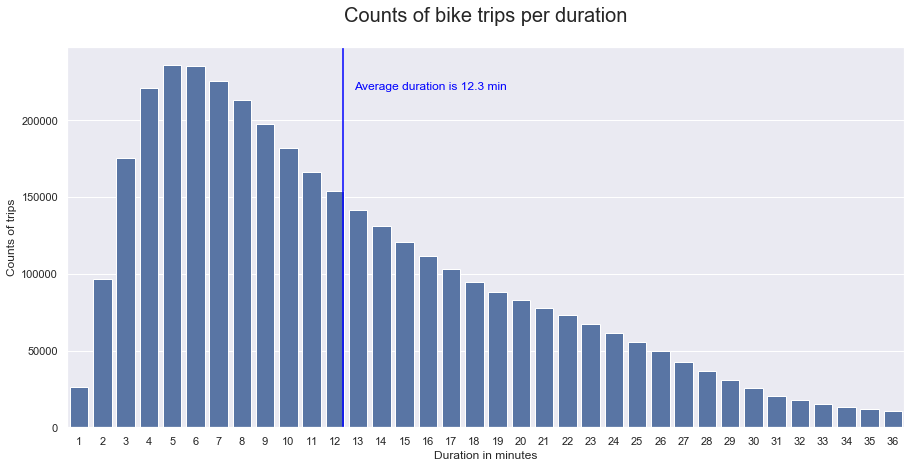

In [41]:
plt.subplots(figsize=(15,7))
sns.countplot(x="duration", data = chicago_2017, color = sns.color_palette()[0])
sns.set()


blue1 = chicago_2017.duration.mean()

plt.axvline(x=blue1-1, color = 'blue')
plt.text(blue1-.5,220000,
         "Average duration is {} min".format(blue1.round(1)),
         color = "blue", fontsize = 12)

plt.xlabel('Duration in minutes')
plt.ylabel('Counts of trips')
plt.title('Counts of bike trips per duration',
          fontsize = 20, y = 1.05);

The bike trip duration distribution si skewed to the left, with a top duration being 6 min. The average duration over the complete dataset is 12.7 min

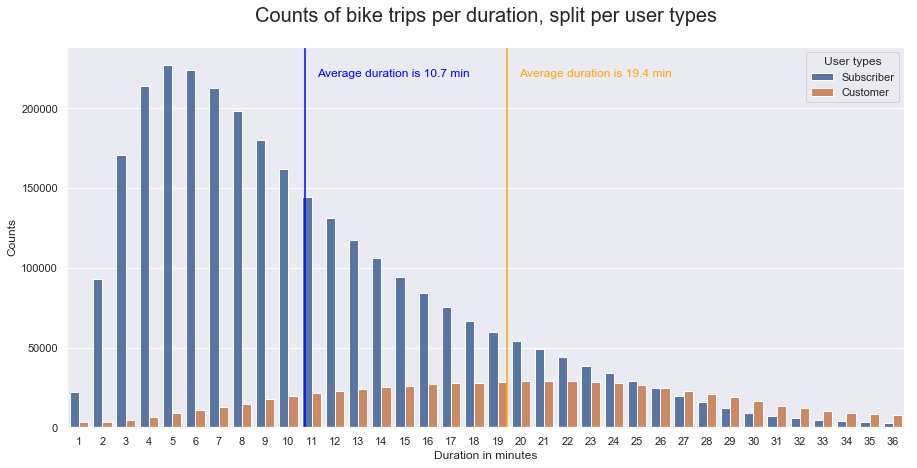

In [42]:
plt.subplots(figsize=(15,7))
sns.countplot(x="duration", data = chicago_2017, hue = "usertype")
sns.set()

blue2 = chicago_2017.query('usertype == "Subscriber"').duration.mean()
orange = chicago_2017.query('usertype == "Customer"').duration.mean()

plt.axvline(x=blue2-1, color = 'blue')
plt.text(blue2-.5,220000,
         "Average duration is {} min".format(blue2.round(1))
         ,color = "blue", fontsize = 12)

plt.axvline(x=orange-1, color = 'orange')
plt.text(orange-.5, 220000, "Average duration is {} min".format(orange.round(1)),
         color = "orange", fontsize = 12)

plt.xlabel('Duration in minutes')
plt.ylabel('Counts')
plt.title('Counts of bike trips per duration, split per user types',
          fontsize = 20, y = 1.05)
plt.legend(title = 'User types');

The count of trips for the single rider is significantly lower than for members. However, the average bike trip duration is higher for one time customers.

### Subscriber/Customer distribution
[Back to top](https://jocelyngiquel.github.io/udacity-data-visualization/data_viz_divvy.html#Data-Visualization---Communicate-data-findings---Chicago-bike-share-trips-dataset)

What is the bike trip duration per user type?

On the subscribers, how is the gender distribution looking

What is the share of subscribers versus one time customers over 2017?

Is there a difference between working days and weekends?

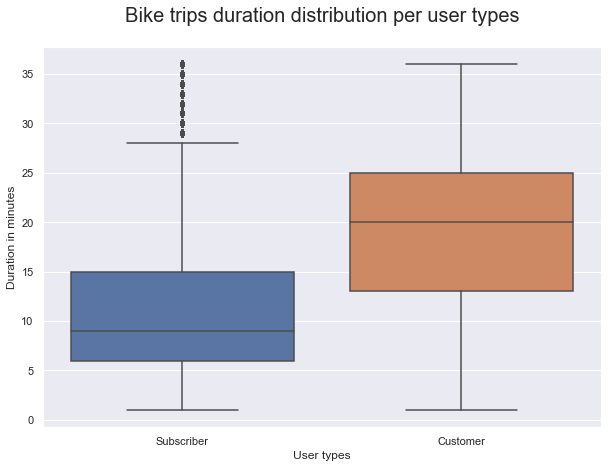

In [43]:
plt.subplots(figsize=(10,7))
sns.boxplot(y = chicago_2017.duration, x = chicago_2017.usertype)
sns.set()

plt.xlabel('User types')
plt.ylabel('Duration in minutes')
plt.title('Bike trips duration distribution per user types',
          fontsize = 20, y = 1.05);

Looking at the boxplot of the bike trip distribution, subscribers have shorter trip duration (distribution skewed left and asymmetic median location than one time customers.

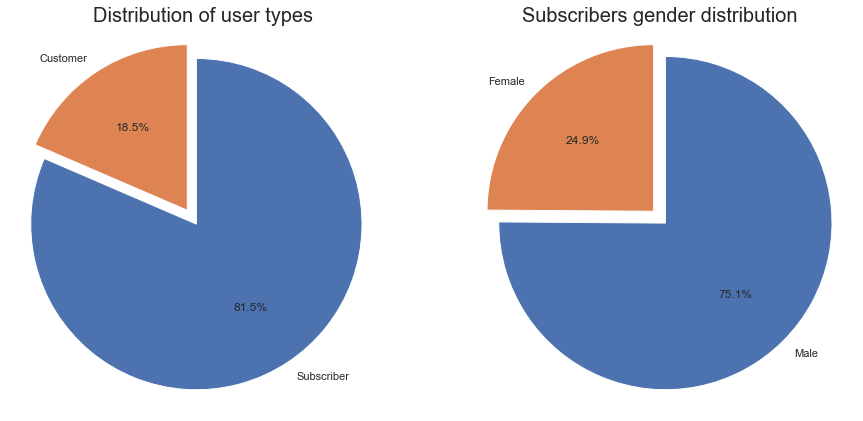

In [70]:
sorted_counts = chicago_2017.usertype.value_counts()
sorted_counts_gender = chicago_2017.query('usertype == "Subscriber"').gender.value_counts()

plt.subplots(figsize=(15,7))
sns.set()
             
plt.subplot(1,2,1)
plt.pie(sorted_counts,
        labels = sorted_counts.index,
        startangle = 90,
        counterclock = False, autopct='%1.1f%%',
        explode = (0, 0.1))
plt.axis('square')
plt.title('Distribution of user types', fontsize = 20)

plt.subplot(1,2,2)
plt.pie(sorted_counts_gender,
        labels = sorted_counts_gender.index,
        startangle = 90,
        counterclock = False,
        autopct='%1.1f%%',
        explode = (0, 0.1))
plt.axis('square')
plt.title('Subscribers gender distribution',
          fontsize = 20);

Subscribers represent the bulk of the Divvy bike users in 2017, and the subscibers are composed by 3/4 of men.

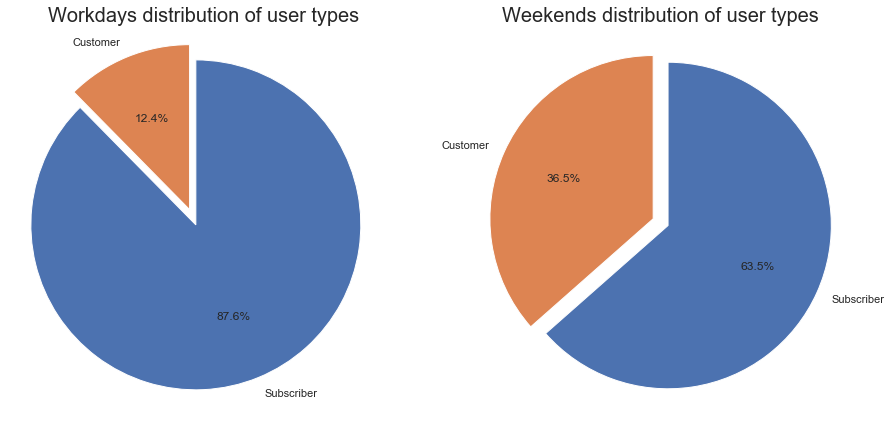

In [75]:
plt.subplots(figsize=(15,7))
sns.set()

plt.subplot(121)
data1 = chicago_2017.query('day_cat == "workdays"').usertype.value_counts()
plt.pie(data1,
        labels = data1.index,
        startangle = 90,
        counterclock = False,
        autopct='%1.1f%%',
        explode = (0, 0.1))
plt.axis('square')
plt.title('Workdays distribution of user types', fontsize = 20)


plt.subplot(122)
data2 = chicago_2017.query('day_cat == "weekends"').usertype.value_counts()
plt.pie(data2,
        labels = data2.index,
        startangle = 90,
        counterclock = False,
        autopct='%1.1f%%',
        explode = (0, 0.1))
plt.axis('square')
plt.title('Weekends distribution of user types',
          fontsize = 20);

The proportions of one time customers rise during weekends to 36% versus 12% during the week.

### Daily trips pattern
[Back to top](https://jocelyngiquel.github.io/udacity-data-visualization/data_viz_divvy.html#Data-Visualization---Communicate-data-findings---Chicago-bike-share-trips-dataset)

What hours of the day are the most and less popular for bike trips using Divvy?

Is there a difference between working days and weekends? And between user types?

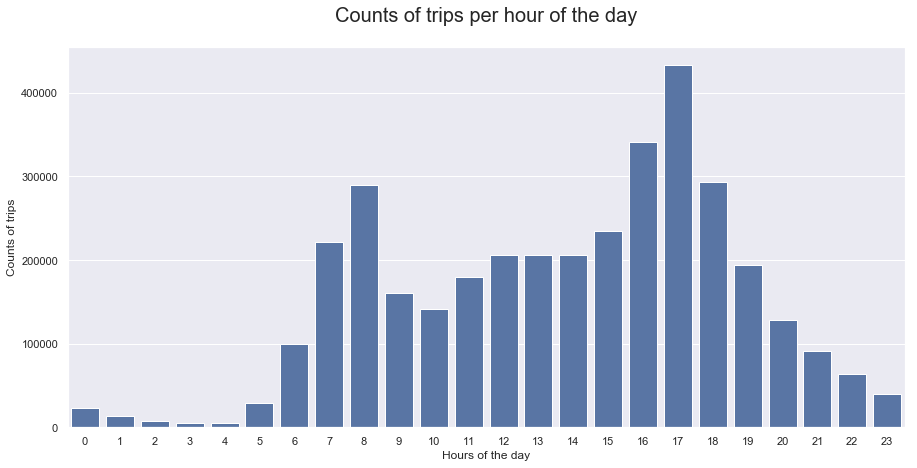

In [42]:
plt.subplots(figsize=(15,7))
sns.countplot(x="day_hour",
              data=chicago_2017,
              color = sns.color_palette()[0])
sns.set()

plt.xlabel('Hours of the day')
plt.ylabel('Counts of trips')
plt.title('Counts of trips per hour of the day',
          fontsize = 20, y = 1.05);

The usage of Divvy bikes is concentrated during daylight (6h to 21h), with two peaks of usage around 8h and 17h.

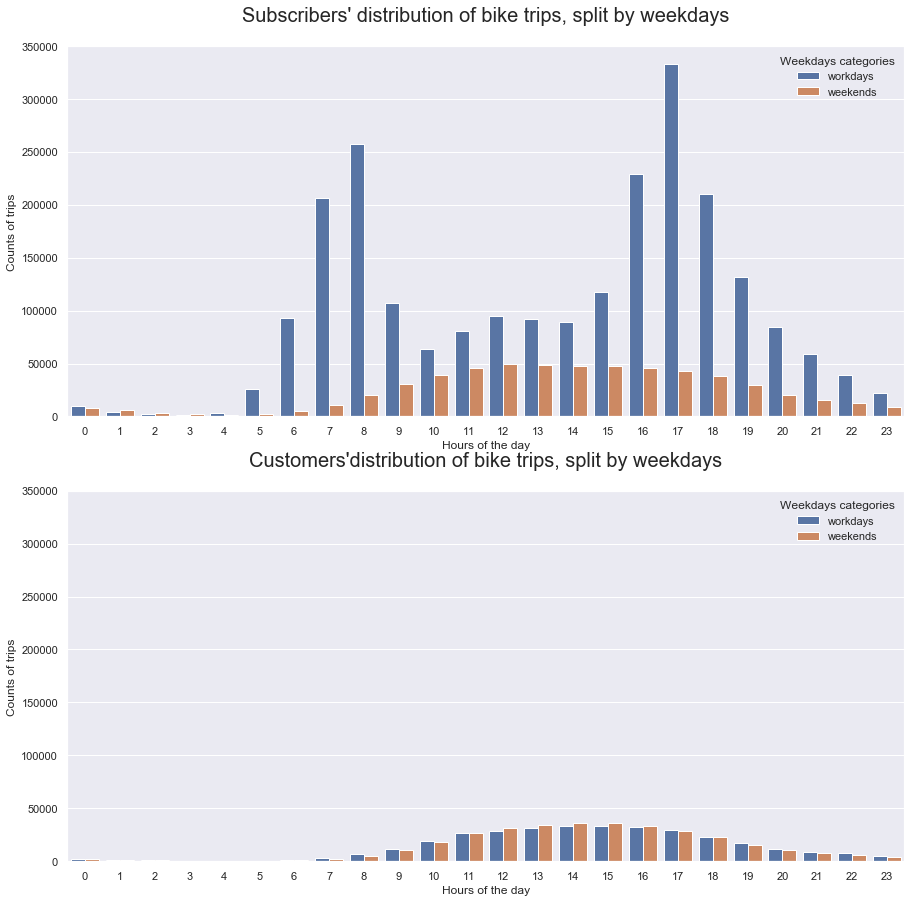

In [76]:
plt.figure(figsize=(15,15))
sns.set()

plt.subplot(2,1,1)
sns.countplot(x="day_hour",
              data=chicago_2017.query('usertype == "Subscriber"'),
              hue = "day_cat")
plt.xlabel('Hours of the day')
plt.ylabel('Counts of trips')
plt.title("Subscribers' distribution of bike trips, split by weekdays",
          fontsize = 20, y = 1.05);
plt.legend(title='Weekdays categories')

plt.subplot(2,1,2)
sns.countplot(x="day_hour",
              data=chicago_2017.query('usertype == "Customer"'),
              hue = "day_cat")
plt.ylim([0, 350000])
plt.xlabel('Hours of the day')
plt.ylabel('Counts of trips')
plt.title("Customers'distribution of bike trips, split by weekdays",
          fontsize = 20, y = 1.05);
plt.legend(title='Weekdays categories');

The count of trips per hour of the day for one time customers is similar between working days and weekends. 

For subscribers, the pattern of trips per hour of the day is different between workdays and weekends. During weekends, the pattenr is similar to the one of one time customers.

### Weekly distribution
[Back to top](https://jocelyngiquel.github.io/udacity-data-visualization/data_viz_divvy.html#Data-Visualization---Communicate-data-findings---Chicago-bike-share-trips-dataset)

For each day of the week, what hours of the day are the most and less popular for bike trips using Divvy?

What day of the week are most and less popular for bike trips?

Is there a difference between one time customers and subscribers?

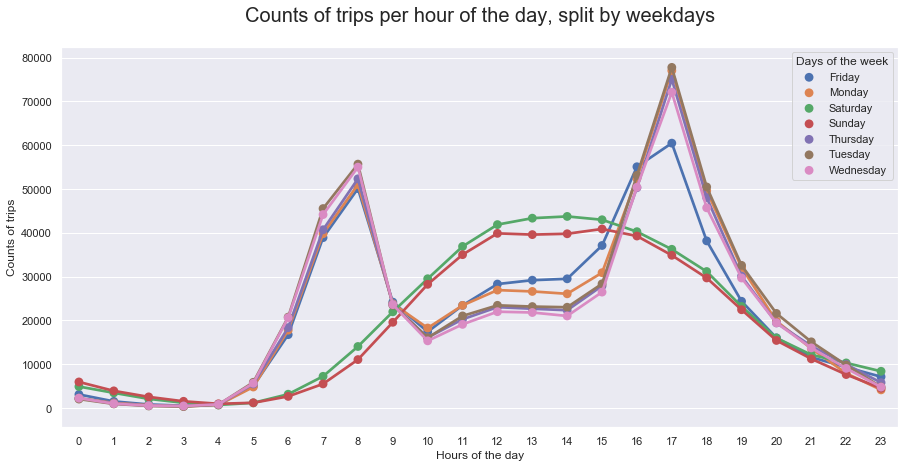

In [43]:
data = chicago_2017.groupby(['day_hour', 'day'], as_index = False).trip_id.count()
plt.subplots(figsize=(15,7))
sns.pointplot(data = data,
              y="trip_id",
              x="day_hour",
              hue="day" )
plt.xlabel('Hours of the day')
plt.ylabel('Counts of trips')
plt.title('Counts of trips per hour of the day, split by weekdays',
          fontsize = 20, y = 1.05)
plt.legend(title = 'Days of the week');

The count of trips on Divvy bikes is uniform on weekdays categories (work days versus weekends)

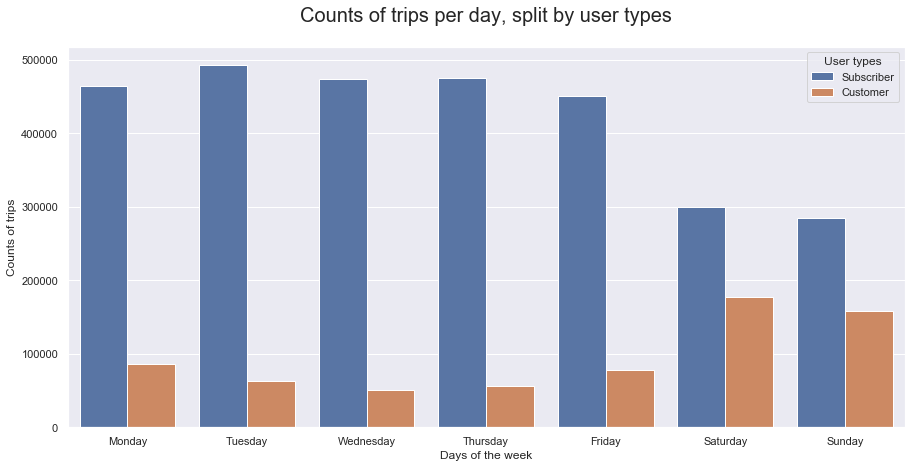

In [50]:
plt.subplots(figsize=(15,7))
sns.set()

sns.countplot(x="day", data=chicago_2017,
              hue = "usertype",
             order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
                      'Friday', 'Saturday', 'Sunday'])
plt.xlabel('Days of the week')
plt.ylabel('Counts of trips')
plt.title('Counts of trips per day, split by user types',
          fontsize = 20, y = 1.05)
plt.legend(title = 'User types');

Monday to Friday are equally popular for bike trips amongst Subscriber, while weekends are more popular for one time customers.

In [46]:
spider_data = chicago_2017.groupby(['day', 'usertype'], as_index = False).trip_id.count()

In [47]:
spider_pivot = spider_data.pivot(index = 'usertype', columns = 'day', values = 'trip_id').reset_index()

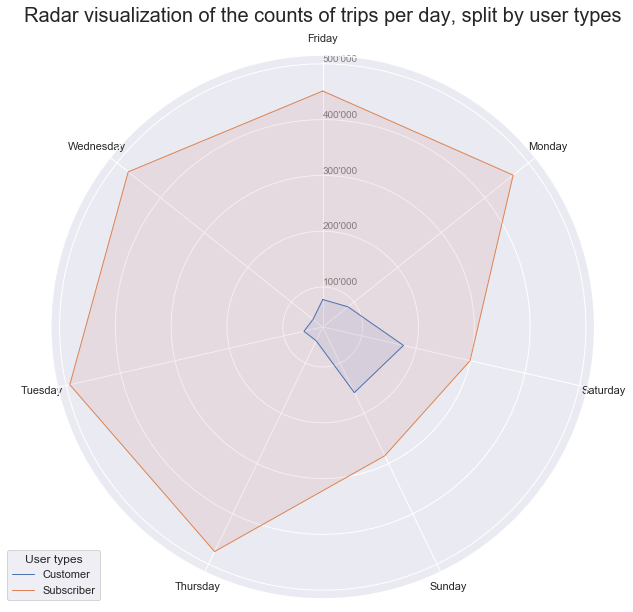

In [48]:
plt.subplots(figsize=(10,10))
sns.set()

# ------- PART 1: Create background
 
# number of variable
categories=list(spider_pivot)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([100000,200000,300000,400000,500000],
           ["100'000","200'000","300'000","400'000","500'000"],
           color="grey",
           size=10)
 
# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
 
# Ind1
values=spider_pivot.loc[0].drop('usertype').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Customer")
ax.fill(angles, values, 'b', alpha=0.1)
 
# Ind2
values=spider_pivot.loc[1].drop('usertype').values.flatten().tolist()
values += values[:1]
ax.plot(angles,
        values,
        linewidth=1,
        linestyle='solid',
        label="Subscriber")
ax.fill(angles, values, 'r', alpha=0.1)
 
# Add legend
plt.legend(title = 'User types',
           loc='upper right',
           bbox_to_anchor=(0.1, 0.1))

# Add title
plt.title('Radar visualization of the counts of trips per day, split by user types',
          fontsize = 20, y = 1.05);


Similar interpretation, with a different radar visualization

### Monthly Distribution
[Back to top](https://jocelyngiquel.github.io/udacity-data-visualization/data_viz_divvy.html#Data-Visualization---Communicate-data-findings---Chicago-bike-share-trips-dataset)

For each month of the year, what hours of the day are the most and less popular for bike trips using Divvy?

What month of the year are most and less popular for bike trips?

Is there a difference between working days and weekends?

In [57]:
tall_data = chicago_2017.groupby(['day_hour', 'month'], as_index = False).trip_id.count()

In [58]:
pivot_data = tall_data.pivot(index = 'day_hour', columns = 'month', values = 'trip_id').reset_index()

In [59]:
pivot_data = pivot_data[['day_hour', 'January', 'February',
                         'March', 'April', 'May', 'June',
                         'July', 'August', 'September',
                         'October', 'November', 'December']]

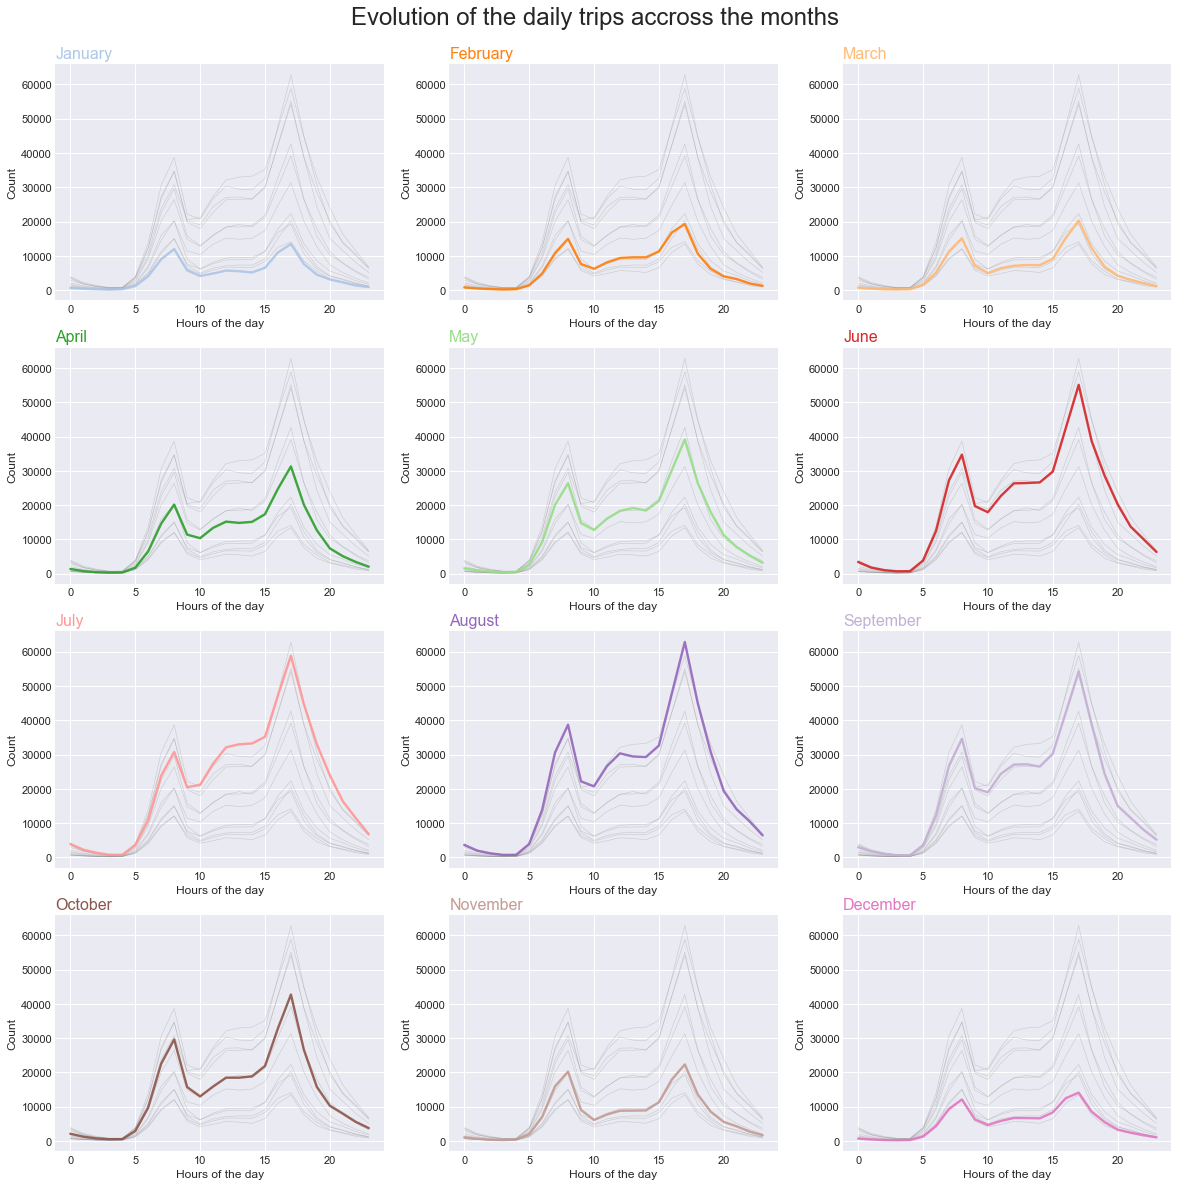

In [60]:
plt.subplots(figsize=(20,20))
sns.set()

plt.suptitle('Evolution of the daily trips accross the months',
             x = 0.5,
             y = 0.92,
             fontsize = 24)
# Initialize the figure
plt.style.use('seaborn-darkgrid')

# create a color palette
palette = plt.get_cmap('tab20')

# multiple line plot
num=0
for column in pivot_data.drop('day_hour', axis=1):
    num+=1
 
    # Find the right spot on the plot
    plt.subplot(4,3, num)
 
    # plot every groups, but discreet
    for v in pivot_data.drop('day_hour', axis=1):
        plt.plot(pivot_data['day_hour'],
                 pivot_data[v],
                 marker='',
                 color='grey',
                 linewidth=0.6,
                 alpha=0.3)
 
    # Plot the lineplot
    plt.plot(pivot_data['day_hour'],
             pivot_data[column],
             marker='',
             color=palette(num),
             linewidth=2.4,
             alpha=0.9,
             label=column)
 
    # Add title
    plt.title(column,
              loc='left',
              fontsize=16,
              fontweight=0,
              color=palette(num))
    plt.ylabel('Count')
    plt.xlabel('Hours of the day')

Month on month, the hourly trip count varies significantly. The count of trip is at his peak during the summer and at his lowest during the winter.

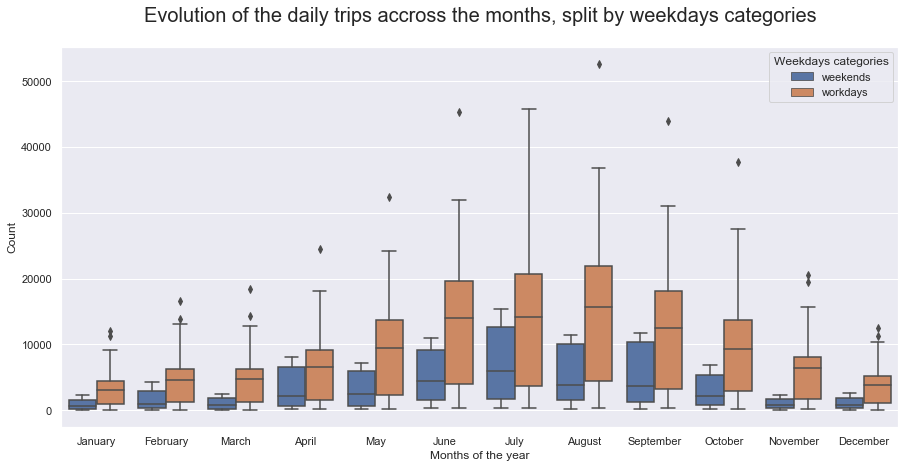

In [59]:
box_data = chicago_2017.groupby(['day_hour', 'month', 'day_cat'],
                                as_index = False).trip_id.count()
plt.subplots(figsize=(15,7))
sns.set()

sns.boxplot(x="month",
            y="trip_id",
            data = box_data,
            hue = "day_cat",
            order = ['January', 'February', 'March', 'April', 'May',
                     'June', 'July', 'August', 'September', 'October',
                     'November', 'December'])
plt.ylabel('Count')
plt.xlabel('Months of the year')
plt.title('Evolution of the daily trips accross the months, split by weekdays categories',
          fontsize = 20, y = 1.05);
plt.legend(title='Weekdays categories');

The distribution of counts of trips per months varies depending on the month. Similar interpretation as the previous chart, the dsictribution of count widen and increases during the summer, while it shorten and decreases during the winter.

### Visualising Geospatial Station Data
[Back to top](https://jocelyngiquel.github.io/udacity-data-visualization/data_viz_divvy.html#Data-Visualization---Communicate-data-findings---Chicago-bike-share-trips-dataset)

Following a post on the visualization of spatial data on this [website](https://blog.prototypr.io/interactive-maps-with-python-part-1-aa1563dbe5a9), we will compute the net arrival or departure from the start stations, per hours of the day. In order to plot the stations on map, we will add the stations longitude and latitude coordinates to the main dataset.


Based on this data set, what is the spatial distribution of the net departures and net arrivals from each bike stations of the Divvy network at the two peak hours (8h and 17h)?

In [14]:
chicago_2017_map = pd.merge(chicago_2017,
                            chicago_stations_df[['id','latitude', 'longitude']],
                            left_on='from_station_id',
                            right_on='id',
                            how='left')

chicago_2017_map.drop(columns='id', inplace=True)

chicago_2017_map.rename(index=str,
                        columns={"latitude":"from_station_latitude",
                                 "longitude":"from_station_longitude"},
           inplace=True)

In [15]:
chicago_2017_map.head()

,start_time,day,month,trip_id,to_station_id,from_station_id,bikeid,duration,day_hour,gender,tripduration,to_station_name,from_station_name,usertype,birthyear,end_time,day_cat,from_station_latitude,from_station_longitude
0,2017-03-31 23:59:07,Friday,March,13518905,171,66,5292,14,23,Male,857,May St & Cullerton St,Clinton St & Lake St,Subscriber,1989.0,2017-04-01 00:13:24,workdays,41.885637,-87.641823
1,2017-03-31 23:56:25,Friday,March,13518904,26,199,4408,3,23,Male,236,McClurg Ct & Illinois St,Wabash Ave & Grand Ave,Subscriber,1990.0,2017-04-01 00:00:21,workdays,41.891466,-87.626761
2,2017-03-31 23:55:33,Friday,March,13518903,432,520,696,5,23,Female,348,Clark St & Lunt Ave,Greenview Ave & Jarvis Ave,Subscriber,1979.0,2017-04-01 00:01:21,workdays,42.015962,-87.668570
3,2017-03-31 23:54:46,Friday,March,13518902,142,110,4915,4,23,Male,288,McClurg Ct & Erie St,Dearborn St & Erie St,Subscriber,1985.0,2017-03-31 23:59:34,workdays,41.893992,-87.629318
4,2017-03-31 23:53:33,Friday,March,13518901,331,327,4247,6,23,Female,415,Halsted St & Blackhawk St (*),Sheffield Ave & Webster Ave,Subscriber,1989.0,2017-04-01 00:00:28,workdays,41.921540,-87.653818


In [16]:
chicago_2017_map = chicago_2017_map.query('from_station_id != to_station_id')

In [17]:
def get_trip_counts_by_hour(selected_hour, chicago_subset):
    # make a DataFrame with locations for each bike station
    locations = chicago_subset.groupby("from_station_id").first()
    locations = locations.loc[:, ["from_station_latitude",
                                 "from_station_longitude",
                                 "from_station_name"]]
    
    #select one time of day
    subset = chicago_subset[chicago_subset["day_hour"]==selected_hour]
    
    # count trips for each destination
    departure_counts =  subset.groupby("from_station_id").count()
    departure_counts = departure_counts.iloc[:,[0]]
    departure_counts.columns= ["Departure Count"]
    
    # count trips for each origin
    arrival_counts =  subset.groupby("to_station_id").count().iloc[:,[0]]
    arrival_counts.columns= ["Arrival Count"]

    #join departure counts, arrival counts, and locations
    trip_counts = departure_counts.join(locations).join(arrival_counts)
    trip_counts = trip_counts[(trip_counts['Departure Count']-trip_counts['Arrival Count'])
                              <(trip_counts['Departure Count']-trip_counts['Arrival Count']).quantile(.95)]
    trip_counts = trip_counts[(trip_counts['Departure Count']-trip_counts['Arrival Count'])
                              >(trip_counts['Departure Count']-trip_counts['Arrival Count']).quantile(.05)]

    return trip_counts

In [23]:
def plot_station_counts(trip_counts):
    # generate a new map
    folium_map = folium.Map(location=[41.8781, -87.6298],
                            zoom_start=12,
                            tiles="CartoDB dark_matter")

    # for each row in the data, add a cicle marker
    for index, row in trip_counts.iterrows():
        # calculate net departures
        net_departures = (row["Departure Count"]-row["Arrival Count"])
        
        # radius of circles
        radius = net_departures/30
        
        # choose the color of the marker
        if net_departures>0:
            color="#E37222" # tangerine
        else:          
            color="#0A8A9F" # teal
        
        # add marker to the map
        folium.CircleMarker(location=(row["from_station_latitude"],
                                      row["from_station_longitude"]),
                            radius=abs(radius),
                            color=color,
                            fill=True).add_to(folium_map)
    return folium_map

In [24]:
trip_counts = get_trip_counts_by_hour(8, chicago_2017_map)
folium_map_8 = plot_station_counts(trip_counts)

folium_map_8.save(outfile='map_8.html')

In [25]:
trip_counts = get_trip_counts_by_hour(17, chicago_2017_map)
folium_map_17 = plot_station_counts(trip_counts)

folium_map_17.save(outfile='map_17.html')

The satial distribution of station with net arrival and net departure at 8h and 17h displays the commuting movement of Divvy users between outside parts of Chicago (residential area) into downtown (workplace locations).

The map output for 8h is available [here](https://jocelyngiquel.github.io/udacity-data-visualization/Chicago_Divvy_8AM.html) and the map output for 17h [here](https://jocelyngiquel.github.io/udacity-data-visualization/Chicago_Divvy_5PM.html).

## References
[Back to top](https://jocelyngiquel.github.io/udacity-data-visualization/data_viz_divvy.html#Data-Visualization---Communicate-data-findings---Chicago-bike-share-trips-dataset)

Kaggle dataset on bike data in SF - https://www.kaggle.com/benhamner/sf-bay-area-bike-share

Python chart gallery with cookbook recipes - https://python-graph-gallery.com/

Python Seaborn documentation - https://seaborn.pydata.org/tutorial.html#tutorial

Blog post on plotting spatial data on a map in Python - https://blog.prototypr.io/interactive-maps-with-python-part-1-aa1563dbe5a9

Folium documentation - https://python-visualization.github.io/folium/docs-v0.6.0/